# **CA4 @ AI Spring 2025**
# Convolutional vs. Fully Connected Neural Networks

- **Name:** sajjad taghizadeh
- **Student ID:** 810102425

---
Your submission should be named using the following format: `AI_CA4_LASTNAME_STUDENTID.ipynb`.

---

 *How to do this problem set:*

- Some questions require writing Python code and computing results, and the rest of them have written answers. For coding problems, you will have to fill out all code blocks that say `YOUR CODE HERE`.

- For text-based answers, you should replace the text that says `WRITE YOUR ANSWER HERE` with your actual answer.
---
If you have any further questions or concerns, contact the TAs via email or Telegram.

# Introduction
In this assignment, you will compare fully connected neural networks with convolutional neural networks to evaluate whether convolutional architectures offer superior performance—and understand the reasons behind any observed differences.

**Important Note:**

Before you begin, please make sure to review the accompanying PyTorch tutorial provided alongside this file.

## Colab Setup

If you are running this notebook on Google Colab, you can mount your Google Drive using the following code to access or upload files directly from your Drive.

In [1]:
# from google.colab import drive
# import os

# drive.mount('/content/drive')

# GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', 'AIS25-CA4')
# os.chdir(GOOGLE_DRIVE_PATH)

## Device

As demonstrated in the PyTorch tutorial, PyTorch enable you to run your code on GPU to accelerate computations.

In [47]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Dataset

## Transforms & Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms. After that, you should split train dataset to train and validation sets. Finally, define the dataloaders for `train`, `validation` and `test`

In [48]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [49]:
from torchvision import transforms

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)),
])

In [50]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torchvision

batch_size = 512

initial_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainset, valset = random_split(initial_trainset, [45000, 5000])

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)



## Visualization

Visualize 5 random images from each class in different columns

- **Hint**:  You can use `plt.subplots` for visualization

In [51]:
# inverse the normilize transform to restore the original data
import torch

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def __call__(self, tensor, gray=False, coeff=(0.3, 0.59, 0.11)):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be unnormalized.
        Returns:
            Tensor: Unnormalized image.
        """
        mean_res = self.mean.to(tensor.device, dtype=tensor.dtype).view(-1, 1, 1)
        std_res = self.std.to(tensor.device, dtype=tensor.dtype).view(-1, 1, 1)

        unnormalized_tensor = tensor.mul(std_res).add(mean_res)

        if gray:
            if unnormalized_tensor.shape[0] == 3:
                weights = torch.tensor(coeff, device=tensor.device, dtype=tensor.dtype).view(3, 1, 1)
                unnormalized_tensor = (unnormalized_tensor * weights).sum(dim=0, keepdim=True)
            elif unnormalized_tensor.shape[0] == 1:
                pass
            else:
                pass

        return unnormalized_tensor
        # YOUR CODE HERE

norminv = UnNormalize(mean=(0.491, 0.482, 0.446), std=(0.247, 0.243, 0.261))


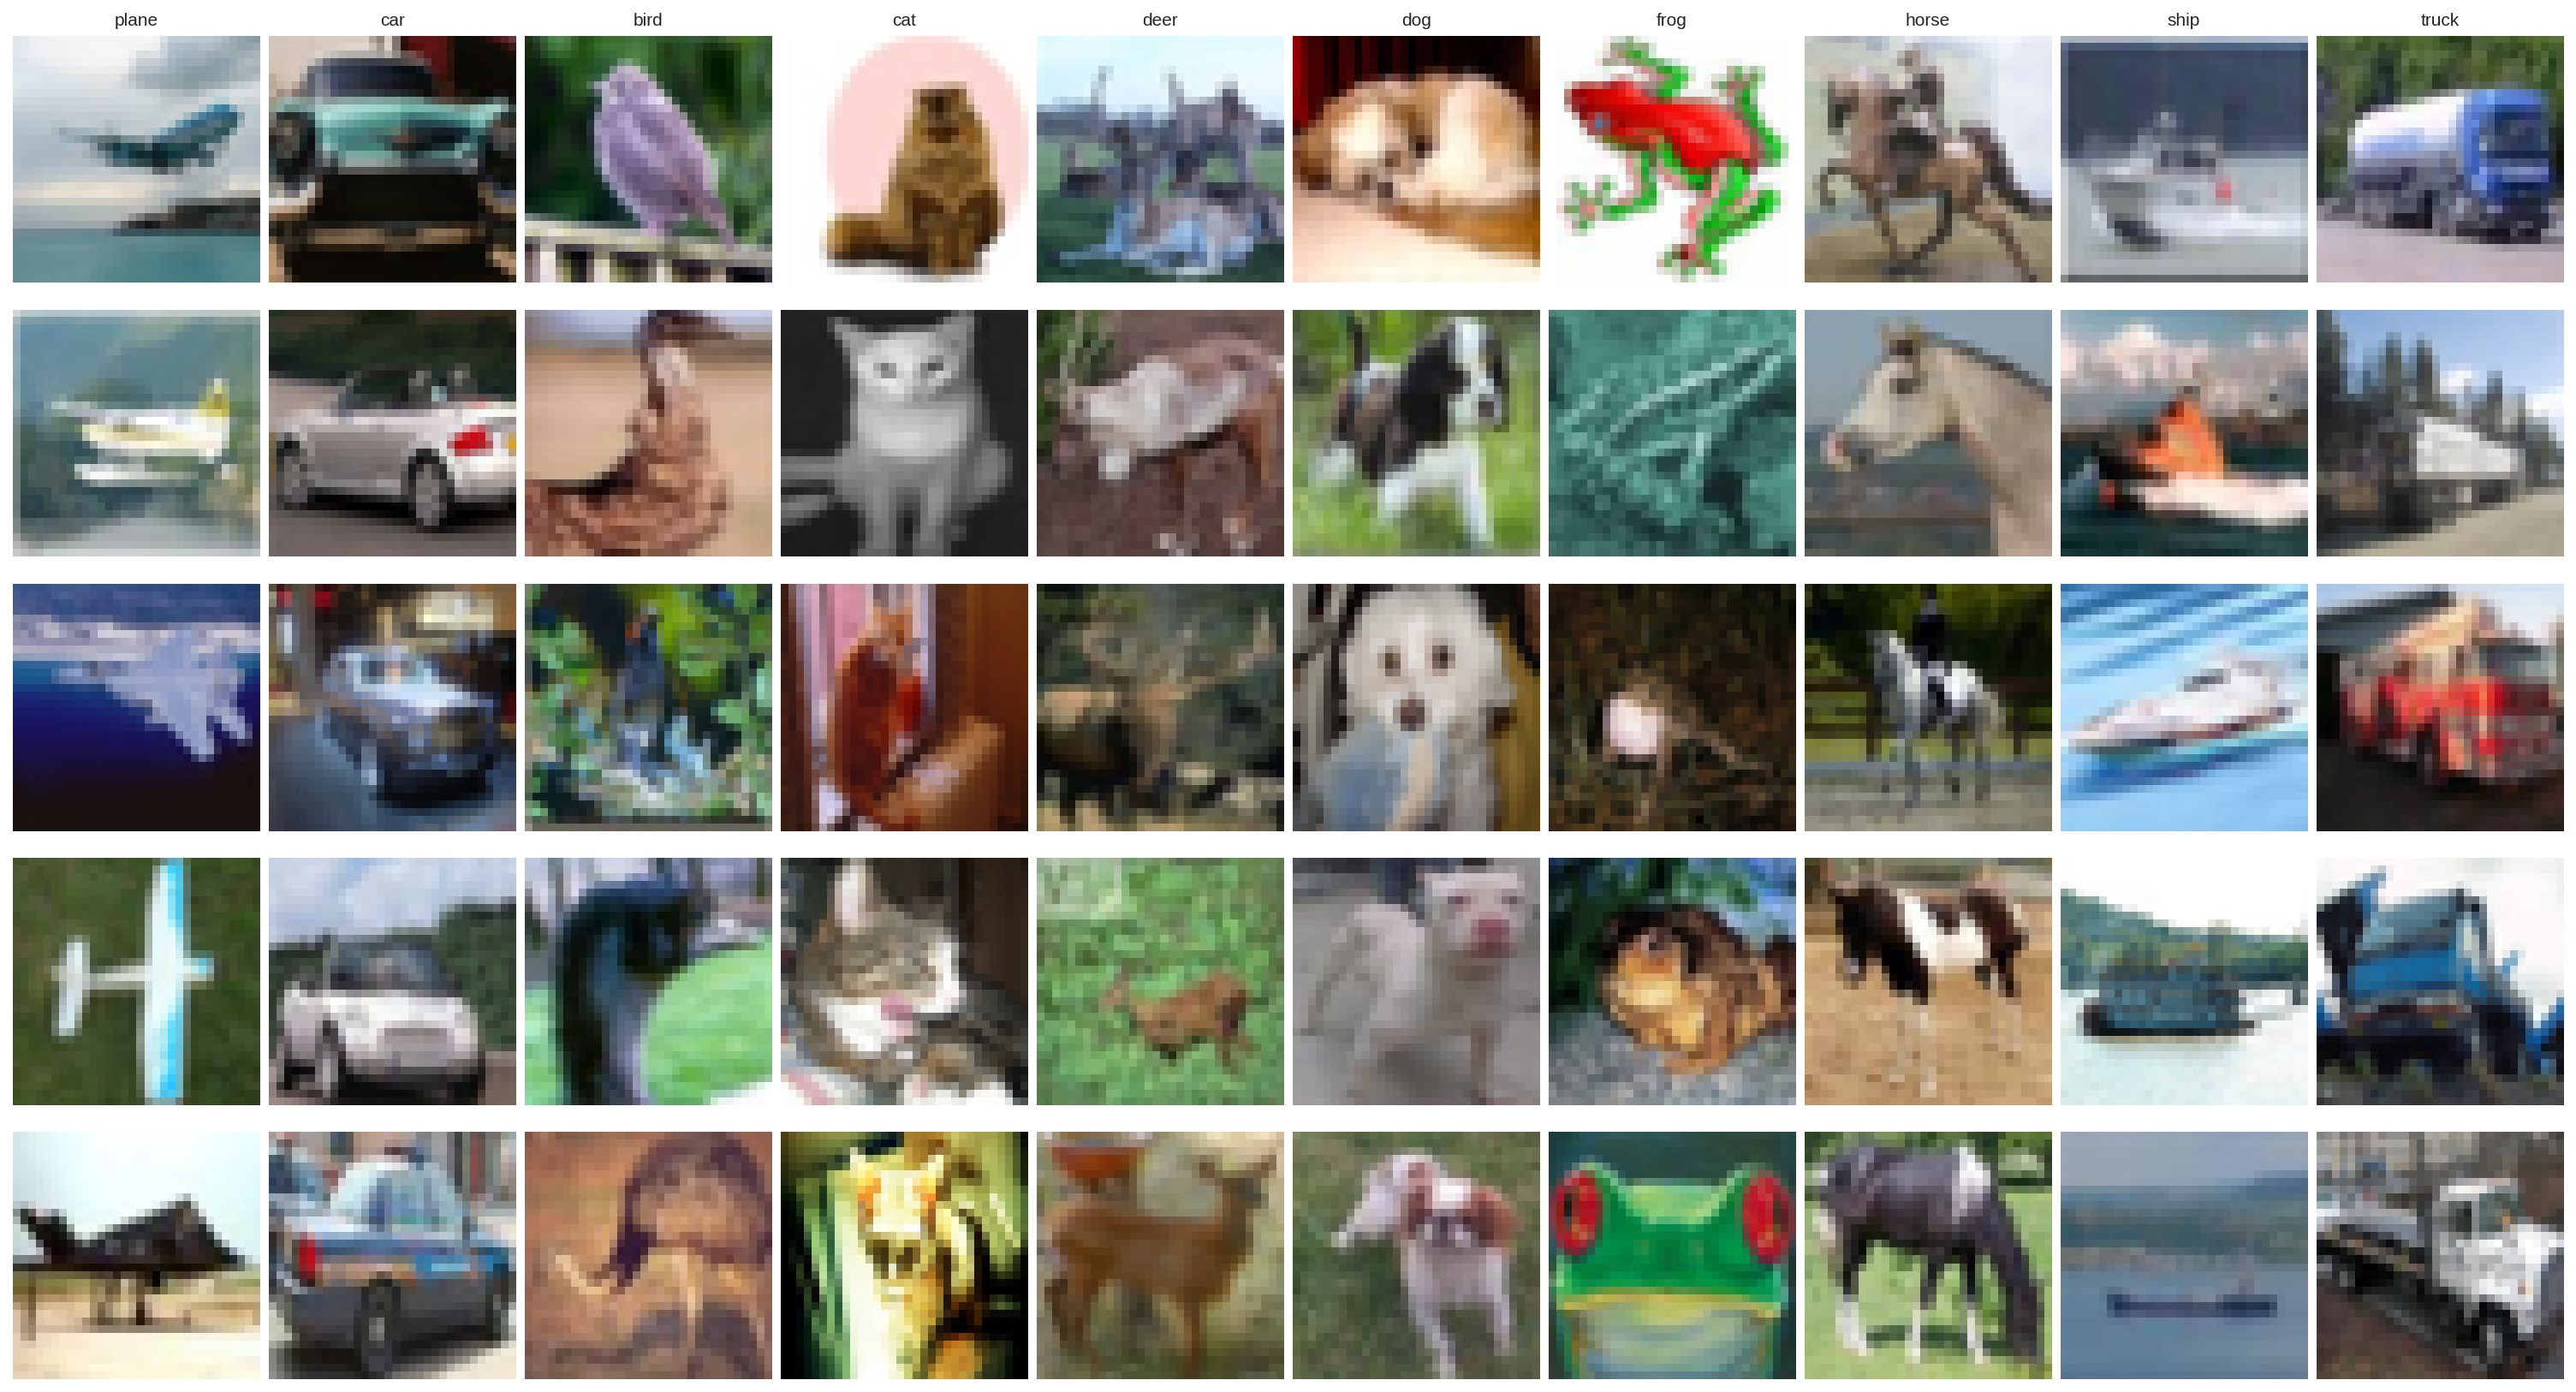

In [52]:
# YOUR CODE HERE
import matplotlib.pyplot as plt
import numpy as np
import random


num_classes = len(classes)
num_images_per_class = 5

class_images_to_show = {class_name: [] for class_name in classes}

images_by_class_indices = {i: [] for i in range(num_classes)}
for idx, data_point in enumerate(trainset):
    _, label = data_point
    if isinstance(label, torch.Tensor):
        label = label.item()
    images_by_class_indices[label].append(idx)


for class_idx, class_name in enumerate(classes):

    possible_indices = images_by_class_indices[class_idx]

    if len(possible_indices) < num_images_per_class:
        selected_indices = random.sample(possible_indices, len(possible_indices))
    else:
        selected_indices = random.sample(possible_indices, num_images_per_class)

    for img_idx in selected_indices:
        image_tensor, _ = trainset[img_idx]
        class_images_to_show[class_name].append(image_tensor)

fig, axes = plt.subplots(num_images_per_class, num_classes, figsize=(num_classes * 2, num_images_per_class * 2.2))

if num_images_per_class == 1 and num_classes == 1:
    axes = np.array([[axes]])
elif num_images_per_class == 1:
    axes = axes.reshape(1, num_classes)
elif num_classes == 1:
    axes = axes.reshape(num_images_per_class, 1)

for j, class_name in enumerate(classes):
    if j < axes.shape[1]:
            axes[0, j].set_title(class_name, fontsize=10)

    images_for_this_class = class_images_to_show.get(class_name, [])
    for i in range(num_images_per_class):
        if i < axes.shape[0] and j < axes.shape[1]:
            ax = axes[i, j]
            ax.axis('off')
            if i < len(images_for_this_class):
                img_tensor_normalized = images_for_this_class[i]

                img_tensor_unnormalized = norminv(img_tensor_normalized)

                img_display = img_tensor_unnormalized.cpu().detach().numpy().transpose((1, 2, 0))
                img_display = np.clip(img_display, 0, 1)

                ax.imshow(img_display)
            else:
                ax.text(0.5, 0.5, 'N/A', ha='center', va='center', fontsize=9)

plt.tight_layout(pad=0.5, h_pad=0.5, w_pad=0.5)
plt.show()





# Fully Connected Neural Netwrok

Your first task is to build a fully connected neural network with PyTorch. To achieve this, it is recommended that you familiarize yourself with the following PyTorch components and incorporate them into your network architecture:

* [`nn.Module`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Module.html)
* [`nn.Sequential`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Sequential.html)
* [`nn.Linear`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html)
* [`nn.ReLU`](https://docs.pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
* [`nn.Dropout`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout.html)
* [`nn.Flatten`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Flatten.html)

In the provided template below, the final layer of the model should be defined separately and assigned the name `linear`, as it will be referenced in a later section of this assignment.

To ensure a fair comparison with convolutional neural networks (CNNs), both models should have approximately the same number of trainable parameters. Specifically, the fully connected model should contain **33,500,000 ± 500,000** trainable parameters.

You will calculate the exact number of trainable parameters in the following subsection to ensure this requirement is met.




In [53]:
import torch
import numpy as np
import torchvision
import torch.nn as nn
import math
from torchvision import transforms

class FullyConnectedNetwork(nn.Module):
    def __init__(self, input_shape=(3, 32, 32), num_classes=10, dropout_p=0.5):
        super(FullyConnectedNetwork, self).__init__()
        # YOUR CODE HERE
        input_features = input_shape[0] * input_shape[1] * input_shape[2]
        h1_features = 10860

        self.flatten = nn.Flatten()

        self.hidden_layers = nn.Sequential(
            nn.Linear(input_features, h1_features),
            nn.BatchNorm1d(h1_features),
            nn.ReLU(),
            nn.Dropout(p=dropout_p)
        )
        self.linear = nn.Linear(h1_features, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.hidden_layers(x)
        x = self.linear(x)
        return x
        # YOUR CODE

## Trainable params

Based on the defined architecture, manually calculate the total number of trainable parameters:

<div style="font-family: Arial, sans-serif; line-height: 1.6;">

<h2 style="color: #2c3e50; border-bottom: 2px solid #3498db; padding-bottom: 10px;">🧠 Neural Network Layer-by-Layer Analysis</h2>


<hr style="border: 0; height: 1px; background-image: linear-gradient(to right, rgba(0, 0, 0, 0), rgba(0, 0, 0, 0.75), rgba(0, 0, 0, 0)); margin: 20px 0;">

<h3 style="color: #3498db;">1️⃣ Layer 1: Flatten Layer</h3>

<p style="color: yellow;">This layer has <strong style="color: #e74c3c;">no trainable parameters</strong>. Its sole purpose is to flatten the input. For example, it converts an input with dimensions <code style="background-color: #f4f4f4; padding: 2px 5px; border-radius: 3px; color: #c0392b;">(3, 32, 32)</code> into a vector with the following number of features:
<code style="background-color: #f4f4f4; padding: 2px 5px; border-radius: 3px; font-weight: bold; color: #27ae60;">32 * 32 * 3 = 3072</code> features.</p>

<hr style="border: 0; height: 1px; background-image: linear-gradient(to right, rgba(0, 0, 0, 0), rgba(0, 0, 0, 0.15), rgba(0, 0, 0, 0)); margin: 15px 0;">

<h3 style="color: #3498db;">2️⃣ Layer 2: Linear Layer (First Hidden Layer)</h3>

<p style="color: yellow;">This layer connects our <code style="background-color: #f4f4f4; padding: 2px 5px; border-radius: 3px; color: #27ae60;">3072</code> inputs to <code style="background-color: #f4f4f4; padding: 2px 5px; border-radius: 3px; color: #2980b9;">10860</code> neurons.
The number of parameters it requires is <code style="background-color: #f0f0f0; padding: 1px 4px; font-size: 0.95em;">(input_features * hidden_neurons) + hidden_neurons (for biases)</code>.</p>
<p style="color: yellow;">Based on your previous <code style="background-color: #ecf0f1; padding: 1px 4px;">torchsummary</code> output, this layer has <strong style="color: #e67e22; font-size: 1.1em;">`33,372,780`</strong> parameters.</p>
<p style="color: #7f8c8d; font-size: 0.9em;"><em>(Calculation: <code style="background-color: #f9f9f9; padding: 1px 3px;">(3072 * 10860) + 10860 = 33,361,920 (weights) + 10,860 (biases) = 33,372,780</code>)</em></p>

<hr style="border: 0; height: 1px; background-image: linear-gradient(to right, rgba(0, 0, 0, 0), rgba(0, 0, 0, 0.15), rgba(0, 0, 0, 0)); margin: 15px 0;">

<h3 style="color: #3498db;">🆕 Layer 3: BatchNorm1d Layer</h3>

<p style="color: yellow;">This layer is added after the first linear layer and before the ReLU activation. It normalizes the activations from the previous layer for each feature dimension.</p>
<p style="color: yellow;">It has <strong style="color: #16a085;">trainable parameters</strong>: a scale (<code style="background-color: #f0f0f0; padding: 1px 4px;">gamma</code>) and a shift (<code style="background-color: #f0f0f0; padding: 1px 4px;">beta</code>) for each of the <code style="background-color: #f4f4f4; padding: 2px 5px; border-radius: 3px; color: #2980b9;">10860</code> features.
Therefore, it adds <code style="background-color: #f4f4f4; padding: 2px 5px; border-radius: 3px; font-weight: bold; color: #27ae60;">2 * 10860 = 21,720</code> parameters.</p>

<hr style="border: 0; height: 1px; background-image: linear-gradient(to right, rgba(0, 0, 0, 0), rgba(0, 0, 0, 0.15), rgba(0, 0, 0, 0)); margin: 15px 0;">

<h3 style="color: #3498db;">4️⃣ Layer 4: ReLU Layer (Activation)</h3>

<p style="color: yellow;">This layer is our activation function, applied after BatchNorm. Structurally, or in terms of having parameters, it doesn't perform special operations and has <strong style="color: #e74c3c;">no trainable parameters</strong>.</p>

<hr style="border: 0; height: 1px; background-image: linear-gradient(to right, rgba(0, 0, 0, 0), rgba(0, 0, 0, 0.15), rgba(0, 0, 0, 0)); margin: 15px 0;">

<h3 style="color: #3498db;">5️⃣ Layer 5: Dropout Layer</h3>

<p style="color: yellow;">This layer aims to prevent overfitting. Its mechanism is such that during the training process, each neuron is temporarily deactivated with a specific probability (e.g., <code style="background-color: #f4f4f4; padding: 2px 5px; border-radius: 3px; color: #8e44ad;">p=0.5</code>). It has <strong style="color: #e74c3c;">no trainable parameters</strong>.</p>

<hr style="border: 0; height: 1px; background-image: linear-gradient(to right, rgba(0, 0, 0, 0), rgba(0, 0, 0, 0.15), rgba(0, 0, 0, 0)); margin: 15px 0;">

<h3 style="color: #3498db;">6️⃣ Layer 6: Output Layer (Final Linear Layer)</h3>

<p style="color: yellow;">This layer receives <code style="background-color: #f4f4f4; padding: 2px 5px; border-radius: 3px; color: #2980b9;">10860</code> inputs (from the output of the <code style="background-color: #ecf0f1; padding: 1px 4px;">self.hidden_layers</code> block) and must produce an output for <code style="background-color: #f4f4f4; padding: 2px 5px; border-radius: 3px; color: #16a085;">10</code> different classes.</p>
<p style="color: yellow;">The number of its parameters is <code style="background-color: #f0f0f0; padding: 1px 4px; font-size: 0.95em;">(input_features * output_classes) + output_classes (for biases)</code>:</p>
<p style="color: yellow;">This means it has <strong style="color: #e67e22; font-size: 1.1em;">`108,610`</strong> parameters.</p>
<p style="color: #7f8c8d; font-size: 0.9em;"><em>(Calculation: <code style="background-color: #f9f9f9; padding: 1px 3px;">(10860 * 10) + 10 = 108,600 (weights) + 10 (biases) = 108,610</code>)</em></p>

<hr style="border: 0; height: 1px; background-image: linear-gradient(to right, rgba(0, 0, 0, 0), rgba(0, 0, 0, 0.75), rgba(0, 0, 0, 0)); margin: 20px 0;">

<h3 style="color: #1abc9c;">🔢 Total Trainable Parameters (Updated):</h3>

<p style="color: yellow;">By summing the parameters of the linear layers and the new BatchNorm layer, we arrive at the .d total number of parameters our model needs to train:</p>
<p style="text-align: center; font-size: 1.1em; margin-top: 10px;">
  <span style="color: #e67e22;">`33,372,780`</span> (parameters from the first linear layer)<br>
  <span style="font-weight: bold; color: #2c3e50;">+</span> <span style="color: #16a085;">`21,720`</span> (parameters from BatchNorm1d layer)<br>
  <span style="font-weight: bold; color: #2c3e50;">+</span> <span style="color: #e67e22;">`108,610`</span> (parameters from the output layer)<br>
  <span style="font-weight: bold; color: #2c3e50;">=</span> <strong style="color: #27ae60; font-size: 1.3em; background-color: #e8f8f5; padding: 5px 10px; border-radius: 5px;">`33,503,110`</strong>
</p>

<p style="color: yellow; font-size: 1.1em; margin-top: 15px;">Therefore, our model now has a total of <strong style="color: #27ae60;">`33,503,110` trainable parameters</strong>. ✨</p>
<p style="color: #555; font-size: 1em; text-align: center;">This new total is still within the target range of <strong style="color: #2980b9;">33,500,000 ± 500,000</strong>.</p>

</div>


<div style="font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; line-height: 1.7; color: #333;">

<h2 style="color: #1a5276; border-bottom: 3px solid #5dade2; padding-bottom: 12px; margin-top: 10px; font-weight: 600;">
  💡 Strategizing Hyperparameters: The Rationale Behind <code style="background-color: #eaf2f8; color: #2980b9; padding: 3px 6px; border-radius: 4px; font-family: 'Courier New', Courier, monospace;">10860</code> Hidden Neurons
</h2>

<p style="font-size: 1.05em; color: blue;">
  The decision to set the number of hidden layer neurons (<code style="background-color: #f2f4f4; color: pink; padding: 2px 5px; border-radius: 3px;">h1_features</code>) to <code style="background-color: #f2f4f4; color: pink; padding: 2px 5px; border-radius: 3px; font-weight: bold;">10860</code> in the <code style="background-color: #f2f4f4; color: pink; padding: 2px 5px; border-radius: 3px;">FullyConnectedNetwork</code> class was not arbitrary. This specific value was derived to meet a key requirement from the problem description concerning the model's complexity.
</p>

<div style="background-color: #f8f9f9; border-left: 5px solid #5dade2; margin: 20px 0; padding: 15px 20px; border-radius: 5px;">
  <p style="margin: 0; font-style: italic; color: blue;">The problem statement specified that:</p>
  <p style="margin: 5px 0 0 0; font-weight: bold; color: #1a5276; font-size: 1.1em;">
    "Your fully connected model should have approximately <span style="color: #d35400;">33,500,000 ± 500,000</span> trainable parameters."
  </p>
</div>

<p style="font-size: 1.05em; color: blue;">
  Consequently, the total count of trainable parameters for our neural network needed to be within the range of <strong style="color: #27ae60;">33,000,000</strong> to <strong style="color: #27ae60;">34,000,000</strong>.
</p>

<hr style="border: 0; height: 2px; background-image: linear-gradient(to right, rgba(0, 0, 0, 0), rgba(44, 62, 80, 0.2), rgba(0, 0, 0, 0)); margin: 30px 0;">

<h3 style="color: #117a65; font-weight: 600;">
  📐 Step-by-Step Calculation to Arrive at <code style="background-color: #e8f6f3; color: #117a65; padding: 3px 6px; border-radius: 4px; font-family: 'Courier New', Courier, monospace;">10860</code>
</h3>

<ol style="padding-left: 25px; color: #34495e;">
  <li style="margin-bottom: 18px;">
    <strong style="color: green;">Network Architecture Outline:</strong>
    <p style="margin-top: 5px;">We selected a relatively simple structure centered around one main hidden layer:</p>
    <ul style="list-style-type: '➤'; margin-left: 20px; padding-left: 10px; margin-top: 8px;">
      <li style="margin-bottom: 6px;">Flattened input (initially <code style="background-color: #f4f4f4; color: #c0392b; padding: 2px 5px; border-radius: 3px;">3 * 32 * 32 = 3072</code> features).</li>
      <li style="margin-bottom: 6px;">A primary linear layer (mapping <code style="background-color: #f4f4f4; color: #7d3c98; padding: 2px 5px; border-radius: 3px;">3072</code> inputs to <code style="background-color: #f4f4f4; color: #7d3c98; padding: 2px 5px; border-radius: 3px;">h1</code> neurons), followed by a ReLU activation function and a Dropout layer.</li>
      <li>A final linear layer (projecting <code style="background-color: #f4f4f4; color: #7d3c98; padding: 2px 5px; border-radius: 3px;">h1</code> neurons to <code style="background-color: #f4f4f4; color: #7d3c98; padding: 2px 5px; border-radius: 3px;">10</code> output classes).</li>
    </ul>
  </li>

  <li style="margin-bottom: 18px;">
    <strong style="color: green;">Parameter Calculation for Linear Layers:</strong>
    <p style="margin-top: 5px;">Each <code style="background-color: #f2f4f4; color: yellow; padding: 2px 5px; border-radius: 3px;">nn.Linear(in_features, out_features)</code> layer contributes <code style="background-color: #f2f4f4; color: pink; padding: 2px 5px; border-radius: 3px; font-family: 'Courier New', Courier, monospace;">(in_features * out_features) + out_features</code> trainable parameters (these account for both weights and biases).</p>
  </li>

  <li style="margin-bottom: 18px;">
    <strong style="color: green;">Breakdown of Parameters in Our Model:</strong>
    <ul style="list-style-type: none; padding-left: 0; margin-top: 5px;">
      <li>First linear layer (<code style="background-color: #f2f4f4; color: pink; padding: 2px 5px; border-radius: 3px;">nn.Linear(3072, h1)</code>):<br>Number of parameters = <code style="background-color: #eef2f7; color: #515a5a; padding: 2px 5px; border-radius: 3px; font-family: 'Courier New', Courier, monospace;">(3072 * h1) + h1</code></li>
      <li style="margin-top: 8px;">Final linear layer (<code style="background-color: #f2f4f4; color: pink; padding: 2px 5px; border-radius: 3px;">self.linear = nn.Linear(h1, 10)</code>):<br>Number of parameters = <code style="background-color: #eef2f7; color: #515a5a; padding: 2px 5px; border-radius: 3px; font-family: 'Courier New', Courier, monospace;">(h1 * 10) + 10</code></li>
      <li style="font-style: italic; color: #7f8c8d; margin-top: 8px;">Note: The Flatten, ReLU, and Dropout layers do not possess any trainable parameters.</li>
    </ul>
  </li>

  <li style="margin-bottom: 18px;">
    <strong style="color: green;">Aggregating Total Trainable Parameters:</strong>
    <div style="background-color: #e8f6f3; border-left: 4px solid #16a085; padding: 12px 15px; margin-top: 8px; border-radius: 4px; font-family: 'Courier New', Courier, monospace; color: #145a32;">
      Sum = [(3072 * h1) + h1] + [(h1 * 10) + 10]<br>
      Sum = 3072*h1 + h1 + 10*h1 + 10<br>
      <strong style="color: #117a65;">Sum = 3083*h1 + 10</strong>
    </div>
  </li>

  <li style="margin-bottom: 18px;">
    <strong style="color: green;">Solving the Equation to Determine `h1`:</strong>
    <p style="margin-top: 5px;">Our objective was for this total sum of parameters to be approximately <strong style="color: #d35400;">33,500,000</strong>:</p>
    <div style="background-color: #e8f6f3; border-left: 4px solid #16a085; padding: 12px 15px; margin-top: 8px; border-radius: 4px; font-family: 'Courier New', Courier, monospace; color: #145a32;">
      3083*h1 + 10 ≈ 33,500,000<br>
      3083*h1 ≈ 33,500,000 - 10<br>
      3083*h1 ≈ 33,499,990<br>
      h1 ≈ 33,499,990 / 3083<br>
      <strong style="color: #117a65;">h1 ≈ 10866.00</strong>
    </div>
  </li>

  <li style="margin-bottom: 18px;">
    <strong style="color: green;">Finalizing the Value for `h1`:</strong>
    <p style="margin-top: 5px;">The derived value for `h1` was approximately <code style="background-color: #f4f4f4; color: #7d3c98; padding: 2px 5px; border-radius: 3px;">10866</code>. For practical purposes and to select a slightly more conventional figure, we opted for <code style="background-color: #f4f4f4; color: #2980b9; padding: 2px 5px; border-radius: 3px; font-weight: bold;">h1_features = 10860</code>.</p>
  </li>
</ol>

<hr style="border: 0; height: 2px; background-image: linear-gradient(to right, rgba(0, 0, 0, 0), rgba(44, 62, 80, 0.2), rgba(0, 0, 0, 0)); margin: 30px 0;">


Once you have completed your hand calculation, you can verify your result by running the following cell:

In [54]:
from torchsummary import summary
summary(FullyConnectedNetwork().to(device), input_size=(3, 32, 32));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                [-1, 10860]      33,372,780
       BatchNorm1d-3                [-1, 10860]          21,720
              ReLU-4                [-1, 10860]               0
           Dropout-5                [-1, 10860]               0
            Linear-6                   [-1, 10]         108,610
Total params: 33,503,110
Trainable params: 33,503,110
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.35
Params size (MB): 127.80
Estimated Total Size (MB): 128.17
----------------------------------------------------------------


## Train

### Model Instantiation

Create an instance of your model and move it to your selected device (CPU or GPU). Refer to the PyTorch-tutorial notebook for guidance on how to perform this operation.

In [55]:
model = FullyConnectedNetwork(input_shape=(3, 32, 32), num_classes=10, dropout_p=0.5)
# YOUR CODE HERE
model.to(device)

if next(model.parameters()).is_cuda:
    print(" GPU ")
else:
    print("CPU")


 GPU 


### Criterion & Optimizer


To train a neural network, we require a **loss function** (referred to as the *criterion*) to quantify the difference between the model's predictions and the true labels. This loss is then used to compute the gradients of the model parameters.

In addition, an **optimization algorithm** is needed to  the model's parameters using the calculated gradients, in order to minimize the loss over time.

You are encouraged to read about the following PyTorch components:

* [`nn.CrossEntropyLoss`](https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
* [`torch.optim.Adam`](https://docs.pytorch.org/docs/stable/generated/torch.optim.Adam.html)

In [58]:
criterion = nn.CrossEntropyLoss() # YOUR CODE HERE
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


### Train loop

Train your model

Tasks:
- Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- save train/validation loss and accuracy (of each epoch) in an array for later usage

In [56]:
def train_epoch(net: torch.nn.Module, criterion: torch.nn.Module, optimizer: torch.optim.Optimizer ,dataloader: torch.utils.data.DataLoader):
    """
    Trains the neural network for a single epoch.

    Args:
        net (torch.nn.Module): The neural network model to be trained.
        criterion (torch.nn.Module): The loss function used to compute the training loss.
        optimizer (torch.optim.Optimizer): The optimization algorithm used to . model parameters.
        dataloader (torch.utils.data.DataLoader): DataLoader providing the training data in batches.

    Returns:
        tuple:
            - avg_loss (float): The average loss across all batches in the epoch.
            - accuracy (float): The classification accuracy (in percentage) over the entire dataset for the epoch.

    Notes:
        - The `criterion` computes the loss between the model's predictions and the true labels.
        - The `optimizer` .s the model's parameters based on the computed gradients to minimize the loss.
    """

    # YOUR CODE HERE

    net.train()

    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    avg_loss, accuracy = None, None
    avg_loss = running_loss / total_samples if total_samples > 0 else 0.0
    accuracy = (correct_predictions / total_samples) * 100.0 if total_samples > 0 else 0.0

    return avg_loss, accuracy

def eval_epoch(net: torch.nn.Module, criterion: torch.nn.Module, dataloader: torch.utils.data.DataLoader, test_mode: bool = False):
    """
    Evaluates the neural network on a validation or test dataset for one epoch.
    """
    net.eval()

    # YOUR CODE HERE
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()


    avg_loss, accuracy = None, None
    avg_loss = running_loss / total_samples if total_samples > 0 else 0.0
    accuracy = (correct_predictions / total_samples) * 100.0 if total_samples > 0 else 0.0
    return avg_loss, accuracy

As previously mentioned, ensuring a fair comparison between models requires consistency in certain aspects of the training setup. One key factor is the number of **trainable parameters**, and another is the number of times the model processes the entire dataset—referred to as an **epoch**.

To maintain consistency in training duration across models, **do not modify** the `epochs` variable defined below.


In [60]:
epochs = 60 # Do not modify

history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}


for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, criterion, optimizer, trainloader)
    val_loss, val_acc = eval_epoch(model, criterion, valloader)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"(Epoch {epoch + 1} / {epochs}) train loss:{train_loss: .4f}; train acc:{train_acc: .2f}%; val loss:{val_loss: .4f}; val_acc:{val_acc: .2f}%")

(Epoch 1 / 60) train loss: 2.0358; train acc: 35.94%; val loss: 1.7213; val_acc: 40.98%
(Epoch 2 / 60) train loss: 1.6613; train acc: 43.05%; val loss: 1.6284; val_acc: 45.12%
(Epoch 3 / 60) train loss: 1.5949; train acc: 45.35%; val loss: 1.6553; val_acc: 43.60%
(Epoch 4 / 60) train loss: 1.5424; train acc: 47.60%; val loss: 1.5540; val_acc: 46.44%
(Epoch 5 / 60) train loss: 1.4708; train acc: 49.59%; val loss: 1.5517; val_acc: 47.46%
(Epoch 6 / 60) train loss: 1.4759; train acc: 49.87%; val loss: 1.5318; val_acc: 47.76%
(Epoch 7 / 60) train loss: 1.4044; train acc: 52.57%; val loss: 1.5323; val_acc: 48.30%
(Epoch 8 / 60) train loss: 1.3718; train acc: 53.34%; val loss: 1.5230; val_acc: 48.80%
(Epoch 9 / 60) train loss: 1.3559; train acc: 54.08%; val loss: 1.5047; val_acc: 49.40%
(Epoch 10 / 60) train loss: 1.3165; train acc: 55.48%; val loss: 1.4578; val_acc: 51.34%
(Epoch 11 / 60) train loss: 1.2614; train acc: 57.05%; val loss: 1.4671; val_acc: 50.52%
(Epoch 12 / 60) train loss: 1.

### Save Model

Save the trained model for use in subsequent sections to avoid retraining it later.


In [61]:
torch.save(model.state_dict(), "fully-connected.pth")

In [15]:
# To load the previously saved model, simply uncomment the code below.
# model.load_state_dict(torch.load('fully-connected.pth'))

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

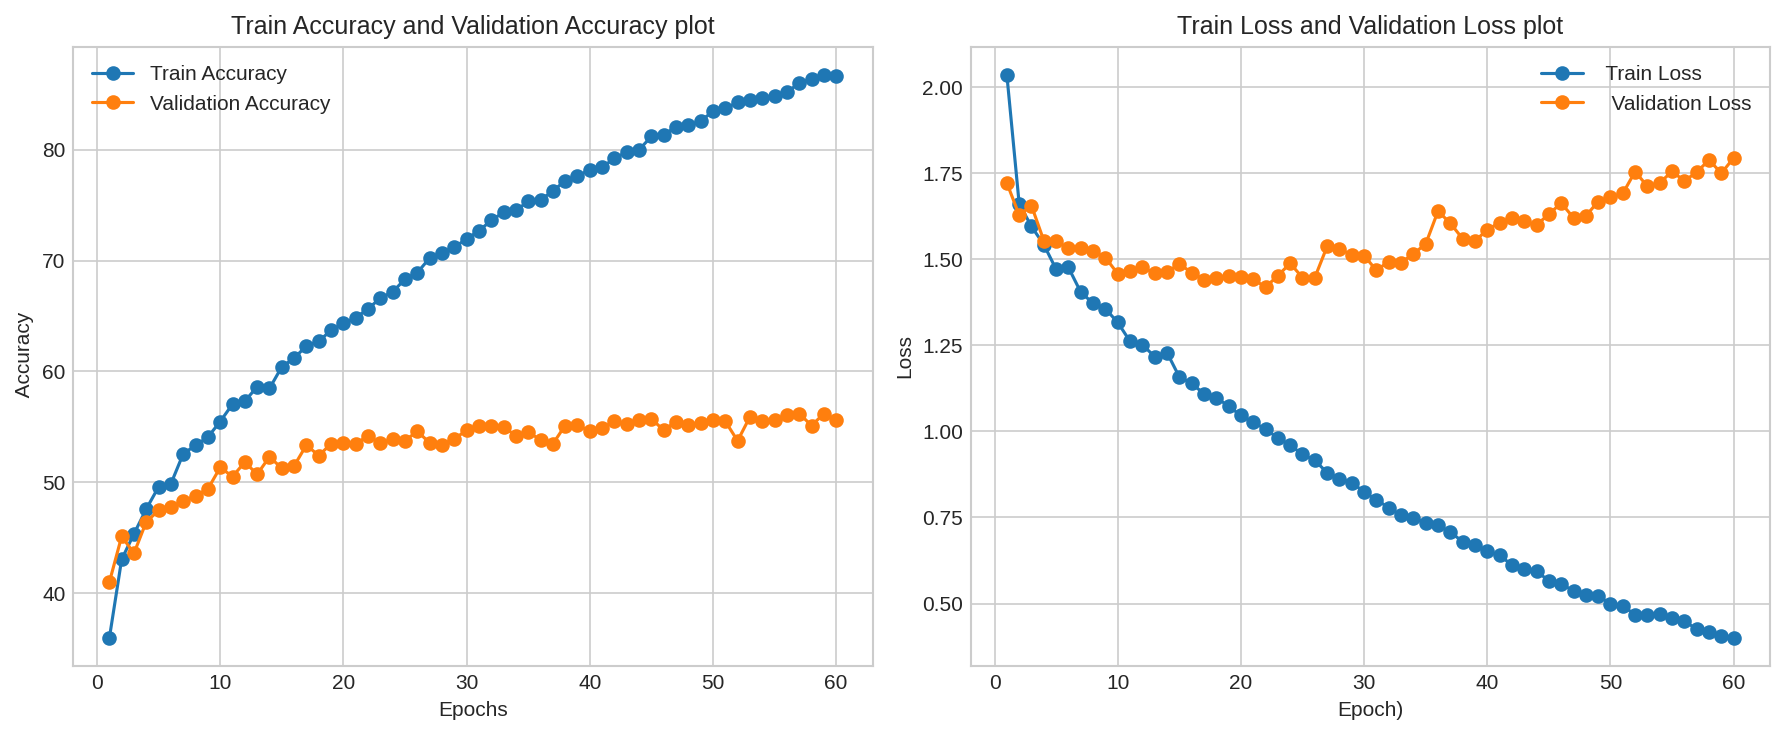

In [62]:
# YOUR CODE HERE


def plot_training_history(history_dict):

    epochs_range = range(1, len(history_dict['train_loss']) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history_dict['train_acc'], 'o-', label='Train Accuracy')
    plt.plot(epochs_range, history_dict['val_acc'], 'o-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel(' Accuracy')
    plt.title('Train Accuracy and Validation Accuracy plot')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history_dict['train_loss'], 'o-', label=' Train Loss')
    plt.plot(epochs_range, history_dict['val_loss'], 'o-', label='  Validation Loss')
    plt.xlabel('Epoch)')
    plt.ylabel('Loss')
    plt.title('Train Loss and Validation Loss plot')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)



## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `60%`

In [63]:
# # YOUR CODE HERE

test_loss, test_accuracy = eval_epoch(model, criterion, testloader, test_mode=True)
print(f"  Test Loss    : {test_loss:.4f}")
print(f"  Test Accuracy       : {test_accuracy:.2f}%")


  Test Loss    : 1.7310
  Test Accuracy       : 56.29%


# Convolutional Neural Network

## Model

Define your model here from scratch (You are not allowed to use the existing models in pytorch)

**NOTICE:** The model that you will have defined outputs a vector containing 10 numbers (for each class). Define a "feature space" that is a vector of size *N* (where *N > 10*) right before the last layer (You can then have a last layer like `nn.Linear(N, 10)`). See the image below to get a better understanding. We will use this later (we want to access the feature space of a sample when the sample is given to the model). The model tries to learn a representation of the samples in this feature space and we will see how good it could do this in later sections.

![Feature Space In Neural Network](https://i.postimg.cc/28Qjcn9D/feature-space-vis.png)

 You are encouraged to learn about the following core components commonly used in convolutional neural networks:

* [`nn.Conv2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
* [`nn.MaxPool2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)

**Reminder**: The model you define should contain 33,500,000 ± 500,000 trainable parameters.

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=10, dropout_p_conv=0.5, dropout_p_fc=0.5):
        super(CNN, self).__init__()

        self.conv_base = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_p_conv),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_p_conv),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_p_conv)


        )

        self.flatten = nn.Flatten()
        self._conv_output_features = 128 * 4 * 4
        self.feature_space_dim_N = 16200

        self.feature_fc_block = nn.Sequential(
            nn.Linear(self._conv_output_features, self.feature_space_dim_N),
            nn.BatchNorm1d(self.feature_space_dim_N),
            nn.ReLU(),
            nn.Dropout(p=dropout_p_fc)
        )

        self.linear = nn.Linear(self.feature_space_dim_N, num_classes)

    def forward(self, x):
        x = self.conv_base(x)
        x = self.flatten(x)

        feature_space_output = self.feature_fc_block(x)
        out_logits = self.linear(feature_space_output)

        return out_logits

    def get_feature_space(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_base(x)
        x = self.flatten(x)
        feature_space_output = self.feature_fc_block(x)
        return feature_space_output

## Trainable params

Based on the defined architecture, manually calculate the total number of trainable parameters:

`WRITE YOUR ANSWER HERE`

<div style="font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; line-height: 1.7; color: #333;">

<h2 style="color: #1a5276; border-bottom: 3px solid #5dade2; padding-bottom: 12px; margin-top: 10px; font-weight: 600;">
🧠 Convolutional Neural Network (CNN) Layer-by-Layer Analysis
</h2>

<p style="font-size: 1.05em; color: #566573;">
  Here's a breakdown of the layers in our updated CNN model and their parameters:
</p>

<hr style="border: 0; height: 2px; background-image: linear-gradient(to right, rgba(0, 0, 0, 0), rgba(44, 62, 80, 0.2), rgba(0, 0, 0, 0)); margin: 30px 0;">

<h3 style="color: #117a65; font-weight: 600;">
  1️⃣ Convolutional Base (<code style="background-color: #e8f6f3; color: #117a65; padding: 2px 5px; border-radius: 3px; font-family: 'Courier New', Courier, monospace;">self.conv_base</code>)
</h3>
<p style="color: yellow;">
  This is the core feature extraction part of our CNN. It consists of multiple blocks, each typically containing:
</p>
<ul style="list-style-type: '✓'; margin-left: 20px; padding-left: 10px; color: yellow;">
  <li style="margin-bottom: 5px;"><code style="background-color: #f2f4f4; color: #1f618d; padding: 2px 5px; border-radius: 3px;">Conv2d</code> layers for learning spatial hierarchies of features.</li>
  <li style="margin-bottom: 5px;"><code style="background-color: #f2f4f4; color: #1f618d; padding: 2px 5px; border-radius: 3px;">BatchNorm2d</code> layers for stabilizing learning and accelerating training.</li>
  <li style="margin-bottom: 5px;"><code style="background-color: #f2f4f4; color: #1f618d; padding: 2px 5px; border-radius: 3px;">ReLU</code> activation functions to introduce non-linearity.</li>
  <li style="margin-bottom: 5px;"><code style="background-color: #f2f4f4; color: #1f618d; padding: 2px 5px; border-radius: 3px;">MaxPool2d</code> layers for down-sampling feature maps.</li>
  <li><code style="background-color: #f2f4f4; color: #1f618d; padding: 2px 5px; border-radius: 3px;">Dropout</code> layers (with <code style="background-color: #f0f0f0;">dropout_p_conv</code>) after pooling to prevent overfitting in convolutional layers.</li>
</ul>
<p style="color: yellow;">
  In our specific architecture (with 3 main blocks, each containing two Conv2d layers and their associated BatchNorm/ReLU, followed by MaxPool and Dropout):
</p>
<ul style="list-style-type: none; padding-left: 0;">
  <li>The input image <code style="background-color: #f4f4f4; color: #c0392b; padding: 2px 5px; border-radius: 3px;">(3, 32, 32)</code> is processed through these blocks.</li>
  <li>The final output feature map size from this base is <code style="background-color: #f4f4f4; color: #7d3c98; padding: 2px 5px; border-radius: 3px;">(128, 4, 4)</code>.</li>
  <li>This section has <strong style="color: #e67e22;">`287,904`</strong> trainable parameters.</li>
  <li style="font-style: italic; color: #7f8c8d; font-size: 0.9em;">(Detailed calculation: Block1=10,272 + Block2=55,680 + Block3=221,952)</li>
</ul>

<hr style="border: 0; height: 1px; background-image: linear-gradient(to right, rgba(0, 0, 0, 0), rgba(0, 0, 0, 0.15), rgba(0, 0, 0, 0)); margin: 15px 0;">

<h3 style="color: #117a65; font-weight: 600;">
  2️⃣ Flatten Layer (<code style="background-color: #e8f6f3; color: #117a65; padding: 2px 5px; border-radius: 3px; font-family: 'Courier New', Courier, monospace;">self.flatten</code>)
</h3>
<p style="color: yellow;">
  This layer has <strong style="color: #c0392b;">no trainable parameters</strong>. Its function is to convert the 3D feature maps from the convolutional base into a 1D feature vector.
</p>
<ul style="list-style-type: none; padding-left: 0;">
  <li>Input: <code style="background-color: #f4f4f4; color: #7d3c98; padding: 2px 5px; border-radius: 3px;">(Batch_Size, 128, 4, 4)</code></li>
  <li>Output: <code style="background-color: #f4f4f4; color: #27ae60; padding: 2px 5px; border-radius: 3px;">(Batch_Size, 128 * 4 * 4 = 2048)</code> features.</li>
  <li><code style="background-color: #ecf0f1; padding: 1px 4px;">self._conv_output_features = 2048</code></li>
</ul>

<hr style="border: 0; height: 1px; background-image: linear-gradient(to right, rgba(0, 0, 0, 0), rgba(0, 0, 0, 0.15), rgba(0, 0, 0, 0)); margin: 15px 0;">

<h3 style="color: #117a65; font-weight: 600;">
  3️⃣ Feature Generation FC Block (<code style="background-color: #e8f6f3; color: #117a65; padding: 2px 5px; border-radius: 3px; font-family: 'Courier New', Courier, monospace;">self.feature_fc_block</code>)
</h3>
<p style="color: yellow;">
  This block takes the flattened features and projects them into a high-dimensional "feature space". It consists of:
</p>
<ol style="list-style-type: decimal; margin-left: 20px; padding-left: 10px; color: yellow;">
  <li style="margin-bottom: 5px;">A <strong style="color: #2980b9;">Linear layer</strong> mapping <code style="background-color: #f4f4f4; color: #7d3c98; padding: 2px 5px; border-radius: 3px;">2048</code> features to <code style="background-color: #f4f4f4; color: #7d3c98; padding: 2px 5px; border-radius: 3px;">16200</code> (our <code style="background-color: #ecf0f1; padding: 1px 4px;">self.feature_space_dim_N</code>). Parameters: <strong style="color: #e67e22;">`33,193,800`</strong>.</li>
  <li style="margin-bottom: 5px;">A <strong style="color: #2980b9;">BatchNorm1d layer</strong> for normalizing the <code style="background-color: #f4f4f4; color: #7d3c98; padding: 2px 5px; border-radius: 3px;">16200</code> features. Parameters: <strong style="color: #16a085;">`32,400`</strong>.</li>
  <li style="margin-bottom: 5px;">A <strong style="color: #2980b9;">ReLU activation</strong> function (no trainable parameters).</li>
  <li>A <strong style="color: #2980b9;">Dropout layer</strong> (with <code style="background-color: #f0f0f0;">dropout_p_fc</code>) for regularization (no trainable parameters).</li>
</ol>
<p style="color: yellow;">
  Total parameters for this block: <strong style="color: #e67e22;">`33,193,800 + 32,400 = 33,226,200`</strong>.
</p>

<hr style="border: 0; height: 1px; background-image: linear-gradient(to right, rgba(0, 0, 0, 0), rgba(0, 0, 0, 0.15), rgba(0, 0, 0, 0)); margin: 15px 0;">

<h3 style="color: #117a65; font-weight: 600;">
  4️⃣ Output Layer (<code style="background-color: #e8f6f3; color: #117a65; padding: 2px 5px; border-radius: 3px; font-family: 'Courier New', Courier, monospace;">self.linear</code>)
</h3>
<p style="color: yellow;">
  This is the final fully connected layer that takes the <code style="background-color: #f4f4f4; color: #7d3c98; padding: 2px 5px; border-radius: 3px;">16200</code>-dimensional feature space vector and maps it to the number of output classes (e.g., <code style="background-color: #f4f4f4; color: #16a085; padding: 2px 5px; border-radius: 3px;">10</code>).
</p>
<p style="color: yellow;">
  Number of parameters: <code style="background-color: #f0f0f0; padding: 1px 4px; font-size: 0.95em;">(input_features * output_classes) + output_classes</code>.
  This means it has <strong style="color: #e67e22; font-size: 1.1em;">`162,010`</strong> parameters.
</p>
<p style="color: #7f8c8d; font-size: 0.9em;"><em>(Calculation: <code style="background-color: #f9f9f9; padding: 1px 3px;">(16200 * 10) + 10 = 162,000 (weights) + 10 (biases) = 162,010</code>)</em></p>

<hr style="border: 0; height: 2px; background-image: linear-gradient(to right, rgba(0, 0, 0, 0), rgba(44, 62, 80, 0.2), rgba(0, 0, 0, 0)); margin: 30px 0;">

<h3 style="color: #1abc9c; font-weight: bold;">
  🔢 Grand Total Trainable Parameters:
</h3>
<p style="color: yellow;">
  Summing the parameters from the Convolutional Base, the Feature FC Block, and the Output Layer:
</p>
<p style="text-align: center; font-size: 1.1em; margin-top: 10px; background-color: #f0f8ff; padding: 15px; border-radius: 5px;">
  <span style="color: #d35400;">`287,904`</span> (Convolutional Base)<br>
  <span style="font-weight: bold; color: #2c3e50;">+</span> <span style="color: #2980b9;">`33,226,200`</span> (Feature FC Block)<br>
  <span style="font-weight: bold; color: #2c3e50;">+</span> <span style="color: #d35400;">`162,010`</span> (Output Layer)<br>
  <span style="font-weight: bold; color: #2c3e50; font-size: 1.2em;">=</span> <strong style="color: #27ae60; font-size: 1.4em; background-color: #e8f6f3; padding: 6px 12px; border-radius: 5px;">`33,676,114`</strong>
</p>

<p style="color: yellow; font-size: 1.1em; margin-top: 15px; text-align: center;">
  Therefore, our updated CNN model has a total of <strong style="color: #27ae60;">`33,676,114` trainable parameters</strong>. ✨
</p>
<p style="color: #566573; font-size: 1em; text-align: center;">
  This total is within the target range of <strong style="color: #2980b9;">33,500,000 ± 500,000</strong>.
</p>

</div>


Once you have completed your hand calculation, you can verify your result by running the following cell:

In [19]:
from torchsummary import summary
summary(CNN().to(device), input_size=(3, 32, 32));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,248
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
           Dropout-8           [-1, 32, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          18,496
      BatchNorm2d-10           [-1, 64, 16, 16]             128
             ReLU-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,928
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

## Train

### Model instantiation

Create an instance of your model and move it to `device`

In [32]:
model = CNN(num_classes=10)
model.to(device)


CNN(
  (conv_base): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.5, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.5, inplace=Fals

### Criterion & Optimizer

Define `criterion` and `optimizer`

In [21]:


criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


### Train loop

Train your model

Tasks:
- Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- save train/validation loss and accuracy (of each epoch) in an array for later usage

In [22]:
epochs = 60 # Do not modify
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, criterion, optimizer, trainloader)
    val_loss, val_acc = eval_epoch(model, criterion, valloader)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"(Epoch {epoch + 1} / {epochs}) train loss:{train_loss: .4f}; train acc:{train_acc: .2f}%; val loss:{val_loss: .4f}; val_acc:{val_acc: .2f}%")

(Epoch 1 / 60) train loss: 2.2424; train acc: 35.27%; val loss: 1.6346; val_acc: 43.98%
(Epoch 2 / 60) train loss: 1.4568; train acc: 48.81%; val loss: 1.8301; val_acc: 44.92%
(Epoch 3 / 60) train loss: 1.3143; train acc: 54.50%; val loss: 1.7000; val_acc: 48.78%
(Epoch 4 / 60) train loss: 1.1892; train acc: 59.43%; val loss: 1.3399; val_acc: 57.32%
(Epoch 5 / 60) train loss: 1.1082; train acc: 62.32%; val loss: 1.0439; val_acc: 65.54%
(Epoch 6 / 60) train loss: 1.0096; train acc: 65.70%; val loss: 1.0432; val_acc: 65.42%
(Epoch 7 / 60) train loss: 0.9464; train acc: 67.75%; val loss: 1.1578; val_acc: 64.46%
(Epoch 8 / 60) train loss: 0.9105; train acc: 69.07%; val loss: 0.7551; val_acc: 74.68%
(Epoch 9 / 60) train loss: 0.8676; train acc: 70.47%; val loss: 0.8471; val_acc: 72.06%
(Epoch 10 / 60) train loss: 0.8091; train acc: 72.30%; val loss: 0.6987; val_acc: 76.06%
(Epoch 11 / 60) train loss: 0.7909; train acc: 73.34%; val loss: 0.9417; val_acc: 72.02%
(Epoch 12 / 60) train loss: 0.

### Save Model

Since changes need to be made to the model later on, it is advisable to save your model to avoid having to retrain it in case of any issues.

In [23]:
torch.save(model.state_dict(), "cnn.pth")

In [24]:
# To load the previously saved model, simply uncomment the code below.
# model.load_state_dict(torch.load('cnn.pth'))

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

In [25]:

def plot_training_results(history_data):


    num_epochs = len(history_data['train_loss'])
    epochs_range = range(1, num_epochs + 1)

    plt.style.use('seaborn-v0_8-whitegrid')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    ax1.plot(epochs_range, history_data['train_acc'], 'o-', color='dodgerblue', label='Training Accuracy')
    ax1.plot(epochs_range, history_data['val_acc'], 's-', color='orangered', label='Validation Accuracy')
    ax1.set_title('Model Accuracy', fontsize=16, fontweight='bold')
    ax1.set_xlabel('Epochs', fontsize=14)
    ax1.set_ylabel('Accuracy (%)', fontsize=14)
    ax1.legend(fontsize=12)
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)

    ax2.plot(epochs_range, history_data['train_loss'], 'o-', color='dodgerblue', label='Training Loss')
    ax2.plot(epochs_range, history_data['val_loss'], 's-', color='orangered', label='Validation Loss')
    ax2.set_title('Model Loss', fontsize=16, fontweight='bold')
    ax2.set_xlabel('Epochs', fontsize=14)
    ax2.set_ylabel('Loss', fontsize=14)
    ax2.legend(fontsize=12)
    ax2.tick_params(axis='both', which='major', labelsize=12)
    ax2.grid(True, linestyle='--', alpha=0.7)

    fig.suptitle('CNN Model Training History', fontsize=20, fontweight='bold', y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()





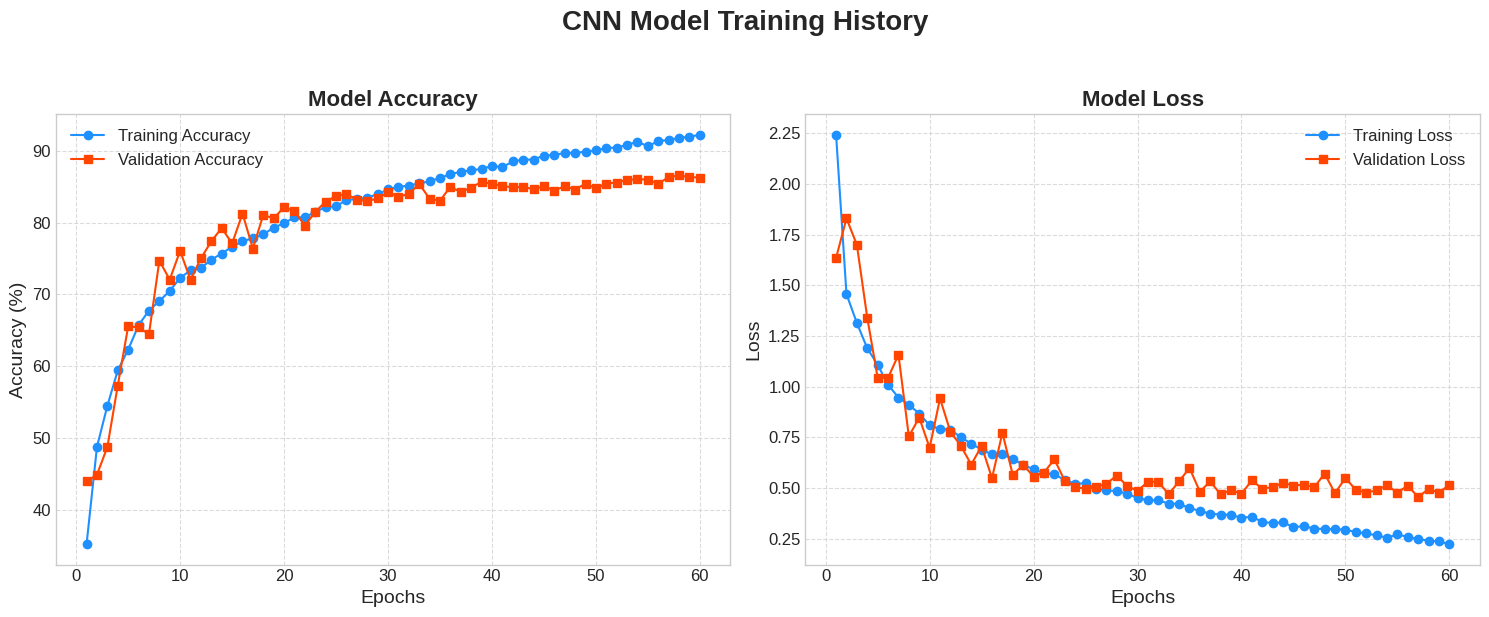

In [26]:
plot_training_results(history)

## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `80%`

In [27]:
test_loss, test_accuracy = eval_epoch(model, criterion, testloader, test_mode=True)

print(f"  Average Test Loss: {test_loss:.4f}")
print(f"  Test Accuracy:     {test_accuracy:.2f}%")

  Average Test Loss: 0.5930
  Test Accuracy:     84.43%


## Visualize incorrectly predicted samples from testset

Visualize *24* random images from testset that are incorrectly predicted by the model. Note that if you used normalization in the transform function for loading the data, you will need to unnormalize the images before displaying them.

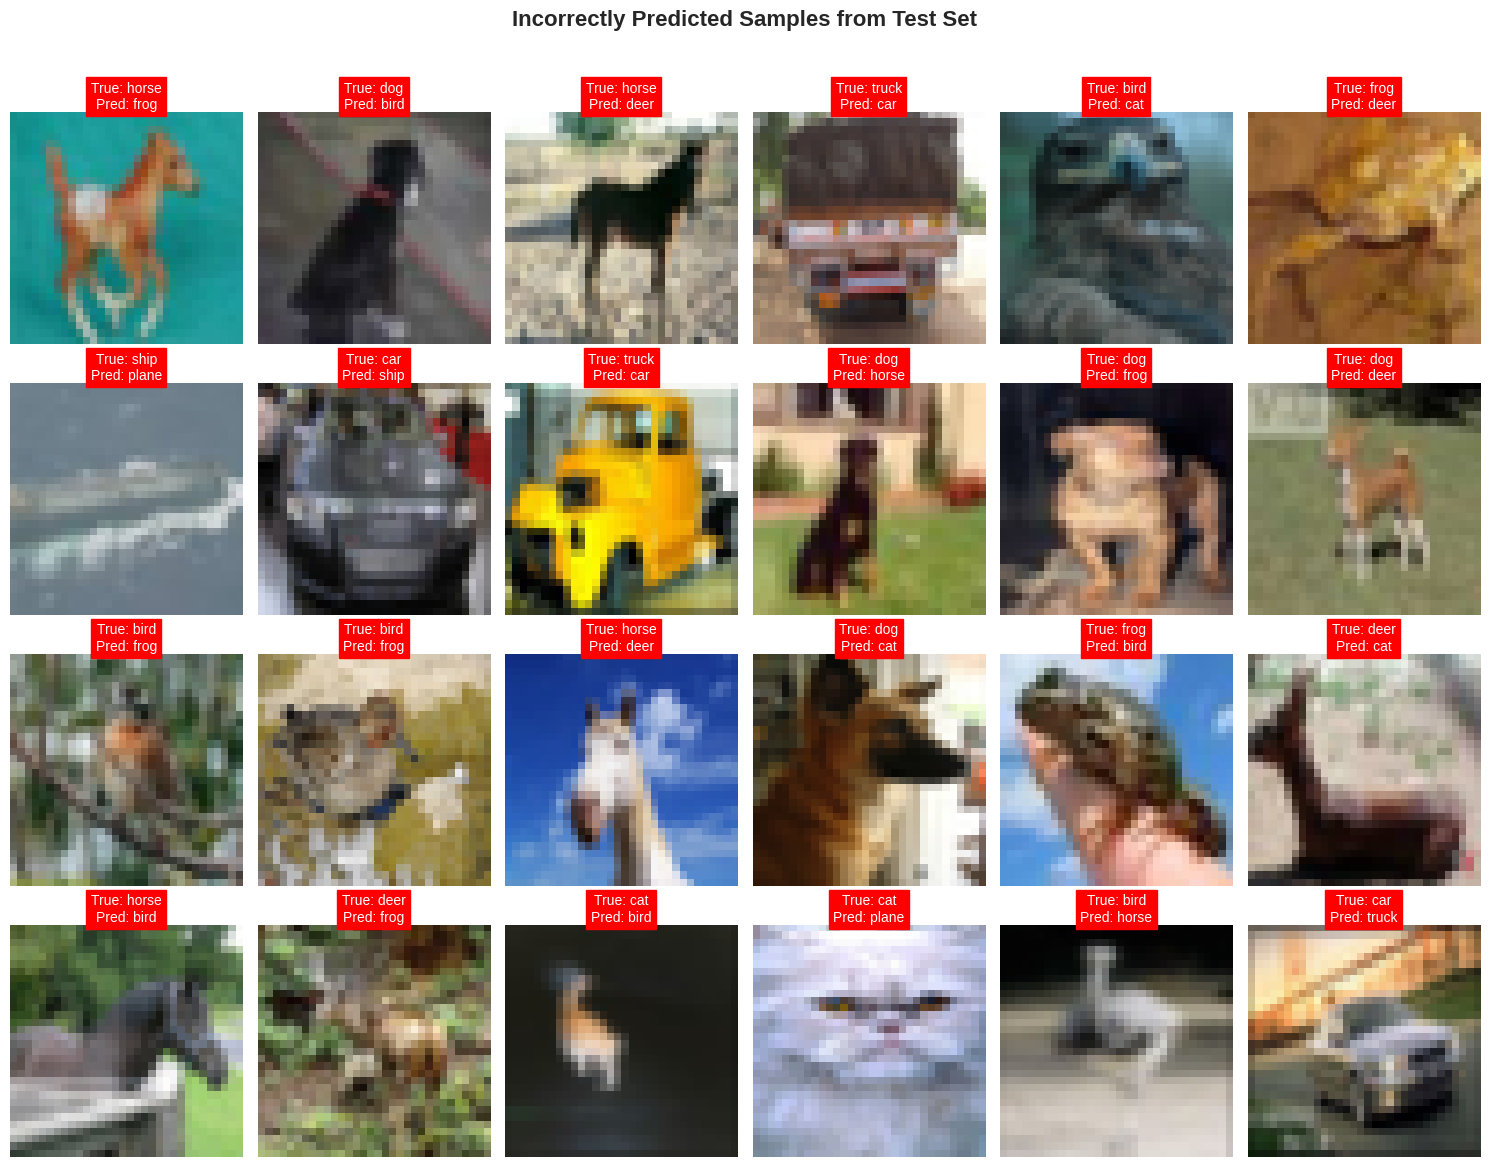

In [28]:
import random

def visualize_incorrect_predictions(model, dataloader, unnormalizer, class_names, num_images=24):
    model.eval()
    incorrect_samples = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            incorrect_indices = (predicted != labels)

            for i in range(images.size(0)):
                if incorrect_indices[i]:
                    incorrect_samples.append({
                        "image": images[i].cpu(),
                        "true_label": labels[i].cpu().item(),
                        "predicted_label": predicted[i].cpu().item()
                    })


    num_to_show = min(num_images, len(incorrect_samples))
    random_samples = random.sample(incorrect_samples, num_to_show)

    rows = int(np.ceil(num_to_show / 6))
    cols = min(num_to_show, 6)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 3))
    fig.suptitle('Incorrectly Predicted Samples from Test Set', fontsize=16, fontweight='bold')
    axes = axes.flatten()

    for i, sample in enumerate(random_samples):
        ax = axes[i]

        img_unnormalized = unnormalizer(sample["image"])

        img_display = img_unnormalized.numpy().transpose((1, 2, 0))
        img_display = np.clip(img_display, 0, 1)

        ax.imshow(img_display)
        ax.axis('off')

        true_label_name = class_names[sample["true_label"]]
        pred_label_name = class_names[sample["predicted_label"]]

        ax.set_title(f"True: {true_label_name}\nPred: {pred_label_name}",
                     color='white', backgroundcolor='red', fontsize=10, pad=2)

    for i in range(num_to_show, len(axes)):
        axes[i].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

visualize_incorrect_predictions(model, testloader, norminv, classes, num_images=24)

## Exploring the feature space

### Calculate the feature space for all training samples

You have trained and evaluated your model. Now, for each sample in the trainset, calculate it's "feature space" discussed in the model section. The result of this section should be a tensor of size `(45000, N)` saved in a variable (for later usage)

- **Hint:** Pay attension to the `shuffle` attribute of your train dataloader (If needed)

In [33]:
from torch.utils.data import DataLoader

def get_all_features(model, dataloader, device):
    model.eval()
    all_features = []

    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)


            features = model.get_feature_space(inputs)

            all_features.append(features.cpu())

    return torch.cat(all_features, dim=0)

train_features_loader = DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


train_features = get_all_features(model, train_features_loader, device)

### K Nearest Neighbor in feature space

We already have calculated the feature spaces for trainset ($S$) in the previous section. Now we follow these steps to explore the featre space:

1. Get 5 random samples from testset which are correctly predicted by the model.
2. for each sample, calculate it's "feature space" ($X$)
3. for each sample, calculate it's *5* nearest neighbors in "feature space" in the trainset (by comparing $X$ to each row in $S$) and visualize them

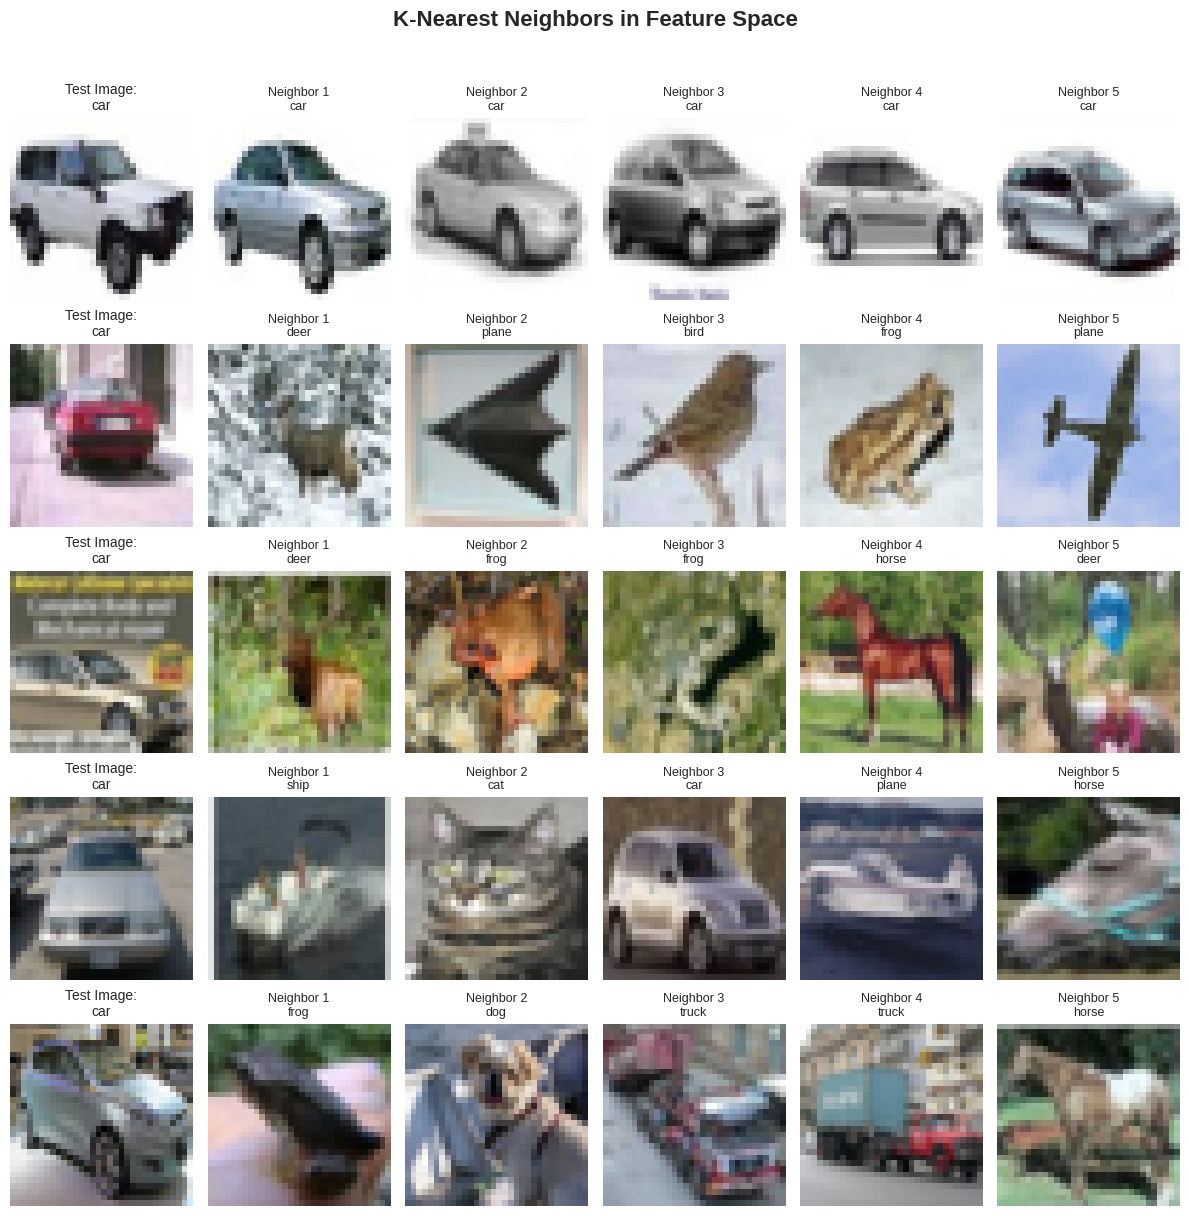

In [36]:
feature_space = None
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

def find_and_visualize_knn_in_feature_space(model, testloader, trainset, train_features, unnormalizer, class_names, device, num_samples=5, k=5):
    model.eval()
    correctly_predicted_samples = []

    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            correct_indices = (predicted == labels)

            for i in range(images.size(0)):
                if correct_indices[i]:
                    correctly_predicted_samples.append({
                        "image": images[i].cpu(),
                        "label": labels[i].cpu().item()
                    })


    random_test_samples = random.sample(correctly_predicted_samples, num_samples)

    test_images = torch.stack([s["image"] for s in random_test_samples])
    test_labels = [s["label"] for s in random_test_samples]

    with torch.no_grad():
        test_features = model.get_feature_space(test_images.to(device)).cpu()

    train_features_gpu = train_features.to(device)

    fig, axes = plt.subplots(num_samples, 1 + k, figsize=((1 + k) * 2, num_samples * 2.5))
    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)

    fig.suptitle('K-Nearest Neighbors in Feature Space', fontsize=16, fontweight='bold')

    for i in range(num_samples):
        current_test_feature = test_features[i].to(device)
        distances = torch.norm(train_features_gpu - current_test_feature, dim=1)

        _, nearest_indices = torch.topk(distances, k, largest=False)
        nearest_indices = nearest_indices.cpu()

        ax = axes[i, 0]
        original_img_unnorm = unnormalizer(test_images[i])
        img_display = original_img_unnorm.numpy().transpose(1, 2, 0)
        img_display = np.clip(img_display, 0, 1)
        ax.imshow(img_display)
        ax.set_title(f"Test Image:\n{class_names[test_labels[i]]}", fontsize=10)
        ax.axis('off')

        for j in range(k):
            ax = axes[i, j + 1]
            neighbor_index = nearest_indices[j].item()
            neighbor_img, neighbor_label = trainset[neighbor_index]

            neighbor_img_unnorm = unnormalizer(neighbor_img)
            img_display = neighbor_img_unnorm.numpy().transpose(1, 2, 0)
            img_display = np.clip(img_display, 0, 1)

            ax.imshow(img_display)
            ax.set_title(f"Neighbor {j+1}\n{class_names[neighbor_label]}", fontsize=9)
            ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

find_and_visualize_knn_in_feature_space(model,testloader,trainset,train_features,norminv,classes,device,num_samples=5,k=5)

### TSNE

Let's follow these steps to explore feature space even more:

1. Sample $M$ ($2000$ would be enought) random samples from the trainset feature space (calculated in the above sections)
2. Now we have a vector of size `(M, N)` where $N$ is the dimension of the feature space
3. Using TSNE reduce $N$ to $2$ (Now we have a vector of size `(M, 2)`)
4. Visualize the points in a 2D plane (Set color of each point based on it's class)


In [40]:
from sklearn.manifold import TSNE

indices = np.random.randint(0, len(feature_space), 2000)
feature_space = feature_space[indices]
tsne = TSNE(n_components=2, random_state=42)
reduced_space = tsne.fit_transform(feature_space.reshape(feature_space.shape[0], -1).detach().cpu().numpy())

<ipython-input-41-3c8a25d776d0>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', len(classes))


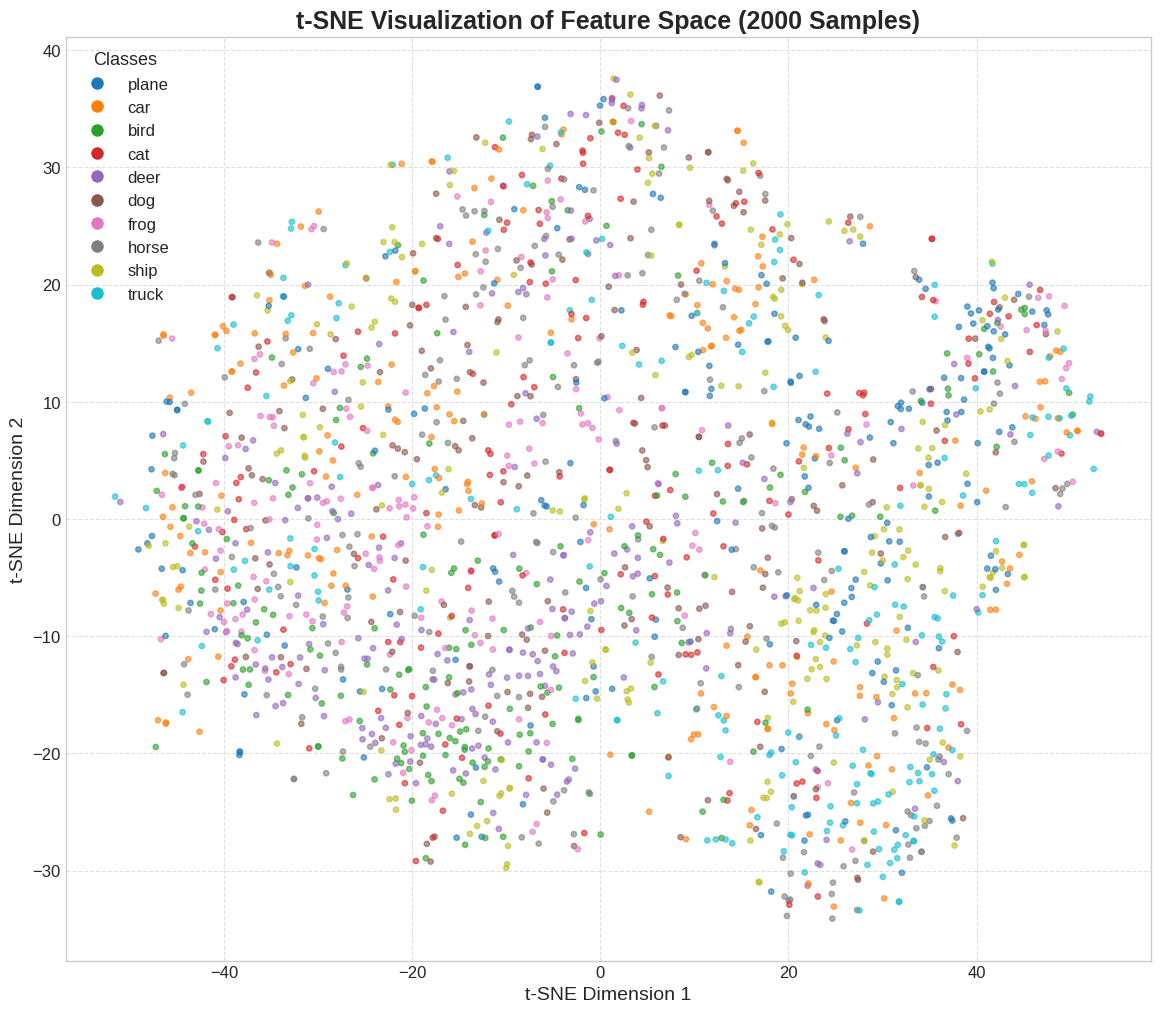

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

feature_space = train_features

all_train_labels = np.array([trainset.dataset.targets[i] for i in trainset.indices])
sampled_labels = all_train_labels[indices]

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 12))

cmap = plt.cm.get_cmap('tab10', len(classes))

scatter = plt.scatter(
    reduced_space[:, 0],
    reduced_space[:, 1],
    c=sampled_labels,
    cmap=cmap,
    alpha=0.6,
    s=15
)

plt.title('t-SNE Visualization of Feature Space (2000 Samples)', fontsize=18, fontweight='bold')
plt.xlabel('t-SNE Dimension 1', fontsize=14)
plt.ylabel('t-SNE Dimension 2', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

legend_handles = []
for i in range(len(classes)):
    legend_handles.append(
        Line2D([0], [0],
               marker='o',
               color='w',
               label=classes[i],
               markerfacecolor=cmap(i),
               markersize=10)
    )

plt.legend(handles=legend_handles, title="Classes", fontsize=12, title_fontsize=13)

plt.show()

### Feature Map


In this part, we are going to visualize the output of one of the convolutional layers to see what features they focus on.

First, let's select a random image from dataset.

In [42]:
image = trainset[3][0]

Now, we are going to *clip* our model at different points to get different intermediate representation.
* Clip your model at least at one point and plot the filters output. You can use the output of first Resnet block.

In order to clip the model, you can use `model.children()` method. For example, to get output only after the first 2 layers, you can do:

```
clipped = nn.Sequential(
    *list(model.children()[:2])
)
intermediate_output = clipped(input)
```



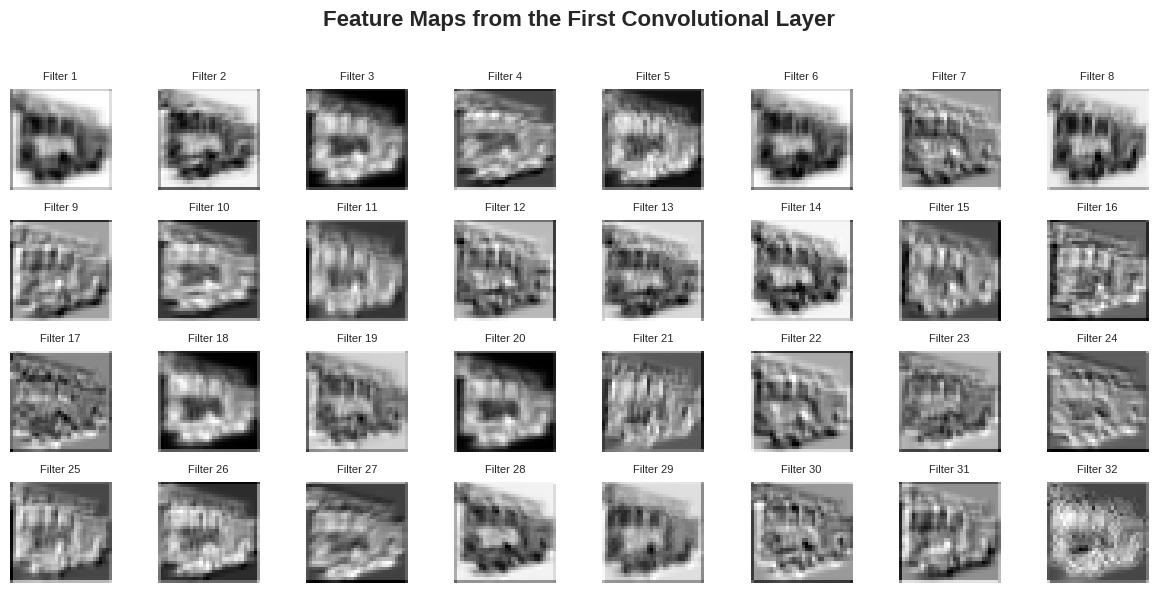

In [43]:
image_for_model = image.unsqueeze(0).to(device)

model.eval()

first_conv_layer = model.conv_base[0]

with torch.no_grad():
    intermediate_output = first_conv_layer(image_for_model)

feature_maps = intermediate_output.squeeze(0).cpu()
num_filters = feature_maps.shape[0]

cols = 8
rows = int(np.ceil(num_filters / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols * 1.5, rows * 1.5))
fig.suptitle('Feature Maps from the First Convolutional Layer', fontsize=16, fontweight='bold')

for i in range(num_filters):
    ax = axes[i // cols, i % cols] if rows > 1 else axes[i % cols]
    ax.imshow(feature_maps[i].numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title(f'Filter {i+1}', fontsize=8)

    ax = axes[i // cols, i % cols] if rows > 1 else axes[i % cols]
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



In [44]:
intermediate_output.shape

torch.Size([1, 32, 32, 32])

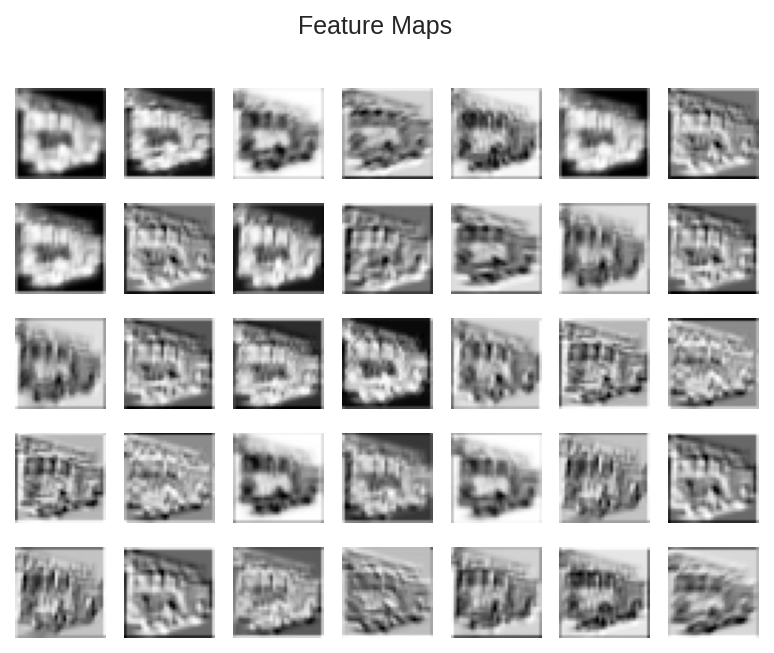

In [45]:
import matplotlib.pyplot as plt

def plot_intermediate_output(result, title=None):
    """
    Plots the intermediate output of shape
    N_FILTERS x H x W
    """
    plt.rcParams['figure.dpi'] = 150
    n_filters = result.shape[1]
    N = int(math.sqrt(n_filters))
    M = (n_filters + N - 1) // N
    assert N * M >= n_filters

    fig, axs = plt.subplots(N, M)
    fig.suptitle(title)

    for i in range(N):
        for j in range(M):
            if i*N + j < n_filters:
                axs[i][j].imshow(result[0, i*N + j].cpu().detach())
                axs[i][j].axis('off')

plot_intermediate_output(intermediate_output, title='Feature Maps')


**Note:** You are expected to analyze all results presented in this notebook and thoughtfully consider the underlying reasons behind them. Be prepared to discuss your insights during the **in-person review session**.
A written report is not required.
